# Load libraries and set device up

In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import seaborn           as sns
import torch.nn          as nn
import os
import torch
import json

from libraries.dataset      import generate_dataset, standardize_dataset
from libraries.model        import GCNN, train, test, EarlyStopping
from torch_geometric.loader import DataLoader

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()

# Define parameters

In [2]:
n_epochs      = 200
batch_size    = 128
learning_rate = 0.001
dropout       = 0.1
patience      = 10
delta         = 2
train_ratio   = 0.8
test_ratio    = 0.1  # val_ratio = 1 - train_ratio - test_ratio

dpi = 50

target = 'bandgap'

input_folder  = 'models'
target_folder = f'{input_folder}/GNN'
model_name    = f'{target_folder}/{target}-model.pt'

# Generate or load graph database for training

In [3]:
labels_name                      = f'{target_folder}/labels.pt'
dataset_name                     = f'{target_folder}/dataset.pt'
dataset_name_std                 = f'{target_folder}/standardized_dataset.pt'
labels_name_std                  = f'{target_folder}/standardized_labels.pt'
standardized_parameters_name_std = f'{target_folder}/standardized_parameters.json'  # Parameters for rescaling the predictions

if not any(os.path.exists(path) for path in [dataset_name_std, standardized_parameters_name_std, labels_name_std, dataset_name, labels_name]):
    # Generate data
    generate_dataset('/home/claudio/cibran/Work/UPC/CLUE/Loaded_PhaseTransition',
                     targets=['EPA', 'bandgap'],
                     data_folder=target_folder)

if all(os.path.exists(path) for path in [dataset_name_std, standardized_parameters_name_std, labels_name_std]):
    # Load the standardized dataset, with corresponding labels and parameters
    dataset = torch.load(dataset_name_std)
    labels  = torch.load(labels_name_std)
    
    # Load the data from the JSON file
    with open(standardized_parameters_name_std, 'r') as json_file:
        numpy_dict = json.load(json_file)
    
    # Convert torch tensors to numpy arrays
    standardized_parameters = {}
    for key, value in numpy_dict.items():
        try:
            standardized_parameters[key] = torch.tensor(value)
        except:
            standardized_parameters[key] = value

elif all(os.path.exists(path) for path in [dataset_name, labels_name]):
    # Load the raw dataset, with corresponding labels, and standardize it
    dataset = torch.load(dataset_name)
    labels  = torch.load(labels_name)
    
    # Standardize dataset
    dataset, labels, standardized_parameters = standardize_dataset(dataset, labels,
                                                                   transformation='inverse-quadratic')
    
    # Save standardized dataset
    torch.save(dataset, dataset_name_std)
    torch.save(labels,  labels_name_std)
    
    # Convert torch tensors to numpy arrays
    numpy_dict = {}
    for key, value in standardized_parameters.items():
        try:
            numpy_dict[key] = value.cpu().numpy().tolist()
        except:
            numpy_dict[key] = value
    
    # Dump the dictionary with numpy arrays to a JSON file
    with open(standardized_parameters_name_std, 'w') as json_file:
        json.dump(numpy_dict, json_file)    

# Load the data from the JSON file
with open(f'{target_folder}/dataset_parameters.json', 'r') as json_file:
    dataset_parameters = json.load(json_file)

# Determine the index for the desired property
target_idx = [idx for idx, t in enumerate(dataset_parameters['target']) if t == target][0]
standardized_parameters['target_mean'] = standardized_parameters['target_mean'][target_idx]
standardized_parameters['target_std']  = standardized_parameters['target_std'][target_idx]

# Defining target factor
target_factor = standardized_parameters['target_std'] / standardized_parameters['scale']

# Select the target we want
for data in dataset:
    data.y = data.y[target_idx]

/tmp/ipykernel_235807/2623356926.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(dataset_name_std)
/tmp/ipykernel_235807/2623356926.py:16: FutureWa

Split dataset

In [4]:
# Define the sizes of the train and test sets
# Corresponds to the size wrt the number of unique materials in the dataset
train_size = int(train_ratio * len(dataset))
test_size  = int(test_ratio  * len(dataset))

np.random.shuffle(dataset)

# Random, fast splitting
train_dataset = dataset[:train_size]
val_dataset   = dataset[train_size:-test_size]
test_dataset  = dataset[-test_size:]

del dataset  # Free up CUDA memory

print(f'Number of training   graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of testing    graphs: {len(test_dataset)}')

Number of training   graphs: 39450
Number of validation graphs: 4932
Number of testing    graphs: 4931


Define data loaders.

In [5]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=True, pin_memory=True)

# Determine number of node-level features in dataset, considering the t_step information
n_node_features = train_dataset[0].num_node_features

del train_dataset, val_dataset, test_dataset  # Free up CUDA memory

# Generate Graph Neural Network model

In [6]:
model = GCNN(features_channels=n_node_features,
                 pdropout=dropout)

# Moving model to device
model = model.to(device)

if os.path.exists(f'{target_folder}/{target}-model.pt'):
    model.load_state_dict(torch.load(f'{target_folder}/{target}-model.pt'), map_location=torch.device(device), weights_only=False)
    model.eval()

# Allow data parallelization among multi-GPU
model= nn.DataParallel(model)
model

DataParallel(
  (module): GCNN(
    (conv1): GraphConv(4, 512)
    (conv2): GraphConv(512, 512)
    (linconv1): Linear(in_features=512, out_features=64, bias=True)
    (linconv2): Linear(in_features=64, out_features=16, bias=True)
    (lin): Linear(in_features=16, out_features=1, bias=True)
  )
)

# Train

Define training optimized and criterion 

In [7]:
# MSELoss is by default defined as the mean within the batch
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# Initialize early stopping
early_stopping = EarlyStopping(patience=patience, delta=delta, model_name=model_name)

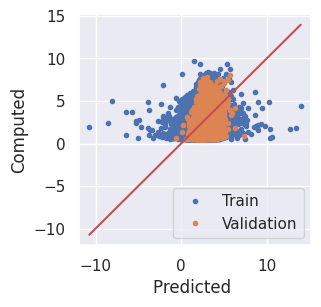

Epoch: 1, Train MAE: 1.3976, Val MAE: 1.3155
Epoch: 2, Train MAE: 1.2934, Val MAE: 1.2516
Epoch: 3, Train MAE: 1.2640, Val MAE: 1.2437
Epoch: 4, Train MAE: 1.2447, Val MAE: 1.2422
Epoch: 5, Train MAE: 1.2327, Val MAE: 1.2219


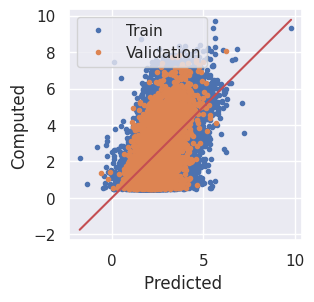

Epoch: 6, Train MAE: 1.2152, Val MAE: 1.1851
Epoch: 7, Train MAE: 1.1989, Val MAE: 1.1870
Epoch: 8, Train MAE: 1.1881, Val MAE: 1.1729
Epoch: 9, Train MAE: 1.1777, Val MAE: 1.1571
Epoch: 10, Train MAE: 1.1713, Val MAE: 1.1540


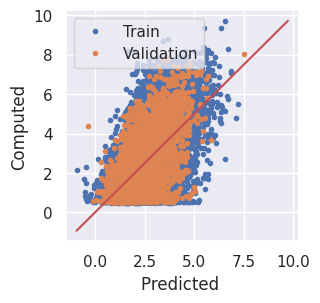

Epoch: 11, Train MAE: 1.1598, Val MAE: 1.1500
Epoch: 12, Train MAE: 1.1477, Val MAE: 1.1329
Epoch: 13, Train MAE: 1.1420, Val MAE: 1.1751
Epoch: 14, Train MAE: 1.1296, Val MAE: 1.1305
Epoch: 15, Train MAE: 1.1222, Val MAE: 1.1457


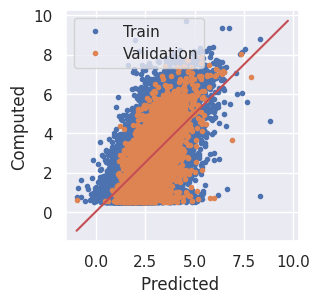

Epoch: 16, Train MAE: 1.1143, Val MAE: 1.1112
Epoch: 17, Train MAE: 1.1038, Val MAE: 1.1055
Epoch: 18, Train MAE: 1.0922, Val MAE: 1.1027
Epoch: 19, Train MAE: 1.0850, Val MAE: 1.0798
Epoch: 20, Train MAE: 1.0759, Val MAE: 1.0698


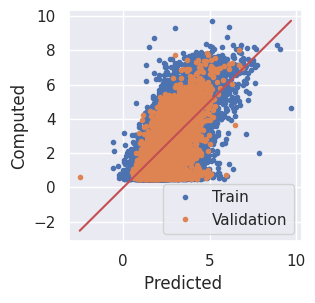

Epoch: 21, Train MAE: 1.0723, Val MAE: 1.0597
Epoch: 22, Train MAE: 1.0603, Val MAE: 1.0614
Epoch: 23, Train MAE: 1.0547, Val MAE: 1.0599
Epoch: 24, Train MAE: 1.0492, Val MAE: 1.0585
Epoch: 25, Train MAE: 1.0446, Val MAE: 1.0600


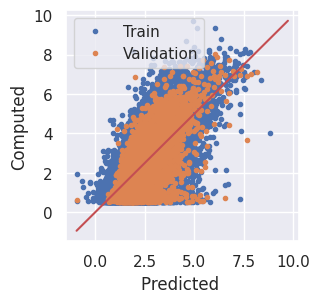

Epoch: 26, Train MAE: 1.0360, Val MAE: 1.0460
Epoch: 27, Train MAE: 1.0274, Val MAE: 1.0410
Epoch: 28, Train MAE: 1.0256, Val MAE: 1.0158
Epoch: 29, Train MAE: 1.0160, Val MAE: 1.0426
Epoch: 30, Train MAE: 1.0183, Val MAE: 1.0354


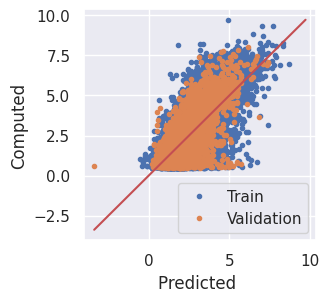

Epoch: 31, Train MAE: 1.0084, Val MAE: 1.0246
Epoch: 32, Train MAE: 1.0046, Val MAE: 1.0130
Epoch: 33, Train MAE: 1.0033, Val MAE: 1.0052
Epoch: 34, Train MAE: 0.9926, Val MAE: 1.0154
Epoch: 35, Train MAE: 0.9913, Val MAE: 1.0028


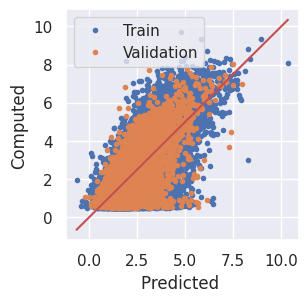

Epoch: 36, Train MAE: 0.9857, Val MAE: 1.0066
Epoch: 37, Train MAE: 0.9859, Val MAE: 1.0073
Epoch: 38, Train MAE: 0.9796, Val MAE: 0.9963
Epoch: 39, Train MAE: 0.9832, Val MAE: 0.9919
Epoch: 40, Train MAE: 0.9705, Val MAE: 1.0104


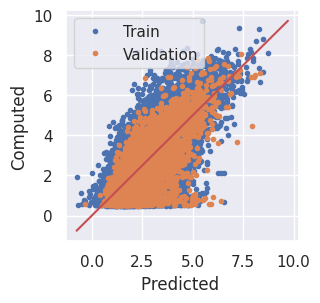

Epoch: 41, Train MAE: 0.9714, Val MAE: 0.9956
Epoch: 42, Train MAE: 0.9579, Val MAE: 0.9799
Epoch: 43, Train MAE: 0.9622, Val MAE: 0.9856
Epoch: 44, Train MAE: 0.9652, Val MAE: 0.9764
Epoch: 45, Train MAE: 0.9525, Val MAE: 0.9637


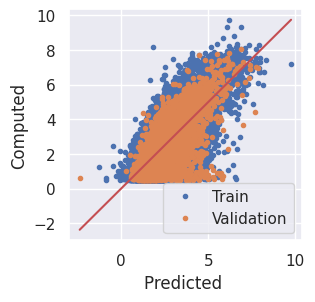

Epoch: 46, Train MAE: 0.9551, Val MAE: 0.9819
Epoch: 47, Train MAE: 0.9527, Val MAE: 0.9638
Epoch: 48, Train MAE: 0.9443, Val MAE: 0.9837
Epoch: 49, Train MAE: 0.9413, Val MAE: 0.9796
Epoch: 50, Train MAE: 0.9435, Val MAE: 0.9765


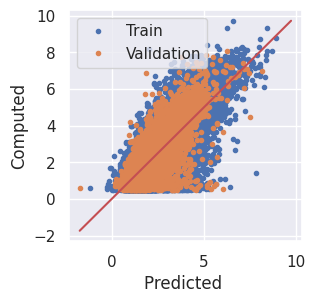

Epoch: 51, Train MAE: 0.9339, Val MAE: 0.9571
Epoch: 52, Train MAE: 0.9355, Val MAE: 0.9679
Epoch: 53, Train MAE: 0.9317, Val MAE: 0.9609
Epoch: 54, Train MAE: 0.9270, Val MAE: 0.9416
Epoch: 55, Train MAE: 0.9310, Val MAE: 0.9606


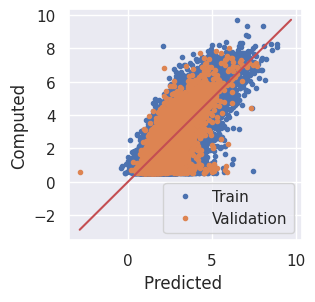

Epoch: 56, Train MAE: 0.9169, Val MAE: 0.9559
Epoch: 57, Train MAE: 0.9263, Val MAE: 0.9612
Epoch: 58, Train MAE: 0.9215, Val MAE: 0.9538
Epoch: 59, Train MAE: 0.9211, Val MAE: 0.9547
Epoch: 60, Train MAE: 0.9156, Val MAE: 0.9424


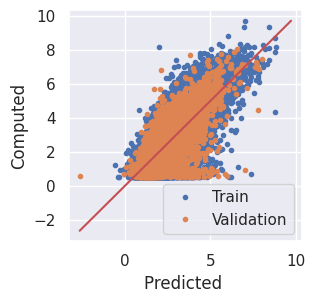

Epoch: 61, Train MAE: 0.9092, Val MAE: 0.9419
Epoch: 62, Train MAE: 0.9110, Val MAE: 0.9399
Epoch: 63, Train MAE: 0.9104, Val MAE: 0.9267
Epoch: 64, Train MAE: 0.9021, Val MAE: 0.9454
Epoch: 65, Train MAE: 0.9007, Val MAE: 0.9287


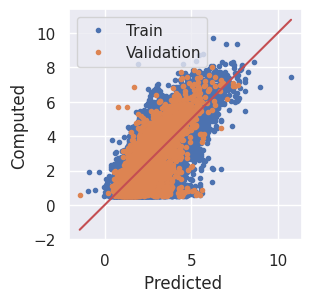

Epoch: 66, Train MAE: 0.9066, Val MAE: 0.9316
Epoch: 67, Train MAE: 0.9006, Val MAE: 0.9407
Epoch: 68, Train MAE: 0.9010, Val MAE: 0.9480
Epoch: 69, Train MAE: 0.8943, Val MAE: 0.9435
Epoch: 70, Train MAE: 0.8923, Val MAE: 0.9387


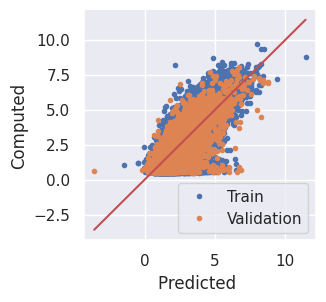

Epoch: 71, Train MAE: 0.8883, Val MAE: 0.9555
Epoch: 72, Train MAE: 0.8922, Val MAE: 0.9340
Epoch: 73, Train MAE: 0.8887, Val MAE: 0.9351
Epoch: 74, Train MAE: 0.8851, Val MAE: 0.9277
Epoch: 75, Train MAE: 0.8843, Val MAE: 0.9147


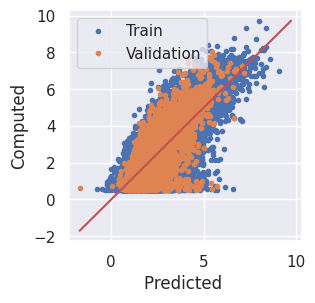

Epoch: 76, Train MAE: 0.8874, Val MAE: 0.9315
Epoch: 77, Train MAE: 0.8795, Val MAE: 0.9357
Epoch: 78, Train MAE: 0.8778, Val MAE: 0.9153
Epoch: 79, Train MAE: 0.8799, Val MAE: 0.9435
Epoch: 80, Train MAE: 0.8752, Val MAE: 0.9350


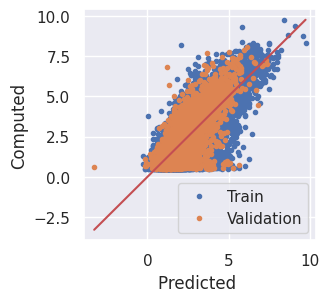

Epoch: 81, Train MAE: 0.8758, Val MAE: 0.9339
Epoch: 82, Train MAE: 0.8748, Val MAE: 0.9315
Epoch: 83, Train MAE: 0.8727, Val MAE: 0.9115
Epoch: 84, Train MAE: 0.8662, Val MAE: 0.9346
Epoch: 85, Train MAE: 0.8664, Val MAE: 0.9400


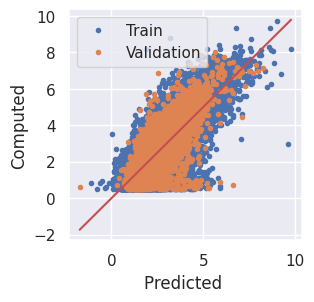

Epoch: 86, Train MAE: 0.8748, Val MAE: 0.9080
Epoch: 87, Train MAE: 0.8631, Val MAE: 0.9254
Epoch: 88, Train MAE: 0.8592, Val MAE: 0.9247
Epoch: 89, Train MAE: 0.8660, Val MAE: 0.8906
Epoch: 90, Train MAE: 0.8591, Val MAE: 0.9158


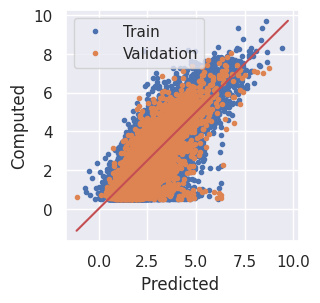

Epoch: 91, Train MAE: 0.8558, Val MAE: 0.9171
Epoch: 92, Train MAE: 0.8564, Val MAE: 0.9126
Epoch: 93, Train MAE: 0.8561, Val MAE: 0.9035
Epoch: 94, Train MAE: 0.8514, Val MAE: 0.9046
Epoch: 95, Train MAE: 0.8523, Val MAE: 0.8925


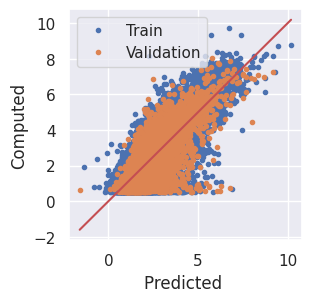

Epoch: 96, Train MAE: 0.8522, Val MAE: 0.9233
Epoch: 97, Train MAE: 0.8535, Val MAE: 0.9061
Epoch: 98, Train MAE: 0.8504, Val MAE: 0.9002
Epoch: 99, Train MAE: 0.8478, Val MAE: 0.9266
Epoch: 100, Train MAE: 0.8455, Val MAE: 0.8981


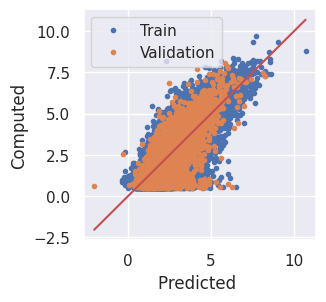

Epoch: 101, Train MAE: 0.8398, Val MAE: 0.9052
Epoch: 102, Train MAE: 0.8389, Val MAE: 0.8863
Epoch: 103, Train MAE: 0.8411, Val MAE: 0.9001
Epoch: 104, Train MAE: 0.8364, Val MAE: 0.8968
Epoch: 105, Train MAE: 0.8387, Val MAE: 0.8981


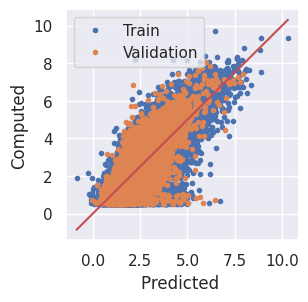

Epoch: 106, Train MAE: 0.8359, Val MAE: 0.9108
Epoch: 107, Train MAE: 0.8403, Val MAE: 0.8923
Epoch: 108, Train MAE: 0.8380, Val MAE: 0.9084
Epoch: 109, Train MAE: 0.8321, Val MAE: 0.8929
Epoch: 110, Train MAE: 0.8289, Val MAE: 0.8881


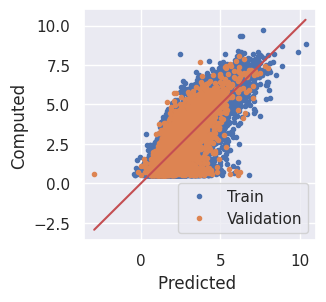

Epoch: 111, Train MAE: 0.8287, Val MAE: 0.9016
Epoch: 112, Train MAE: 0.8282, Val MAE: 0.9072
Epoch: 113, Train MAE: 0.8332, Val MAE: 0.9012
Epoch: 114, Train MAE: 0.8265, Val MAE: 0.8874
Epoch: 115, Train MAE: 0.8268, Val MAE: 0.8892


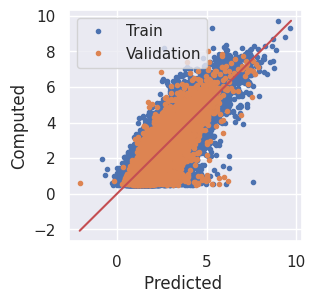

Epoch: 116, Train MAE: 0.8211, Val MAE: 0.8830
Epoch: 117, Train MAE: 0.8236, Val MAE: 0.8833
Epoch: 118, Train MAE: 0.8226, Val MAE: 0.8965
Epoch: 119, Train MAE: 0.8222, Val MAE: 0.9045
Epoch: 120, Train MAE: 0.8219, Val MAE: 0.8921


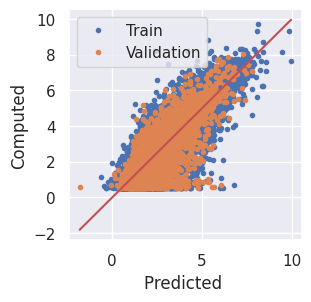

Epoch: 121, Train MAE: 0.8169, Val MAE: 0.8845
Epoch: 122, Train MAE: 0.8130, Val MAE: 0.8929
Epoch: 123, Train MAE: 0.8161, Val MAE: 0.8798
Epoch: 124, Train MAE: 0.8150, Val MAE: 0.8797
Epoch: 125, Train MAE: 0.8176, Val MAE: 0.8895


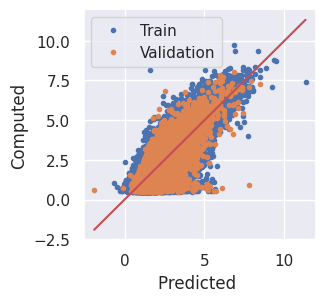

Epoch: 126, Train MAE: 0.8103, Val MAE: 0.8915
Epoch: 127, Train MAE: 0.8139, Val MAE: 0.8942
Epoch: 128, Train MAE: 0.8108, Val MAE: 0.8774
Epoch: 129, Train MAE: 0.8130, Val MAE: 0.8773
Epoch: 130, Train MAE: 0.8050, Val MAE: 0.8888


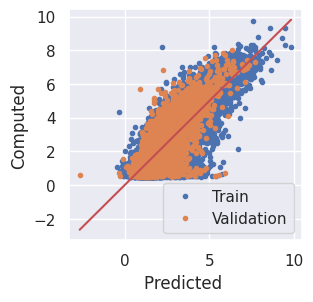

Epoch: 131, Train MAE: 0.8059, Val MAE: 0.8973
Epoch: 132, Train MAE: 0.8063, Val MAE: 0.8784
Epoch: 133, Train MAE: 0.8019, Val MAE: 0.8904
Epoch: 134, Train MAE: 0.8057, Val MAE: 0.8853
Epoch: 135, Train MAE: 0.8028, Val MAE: 0.8775


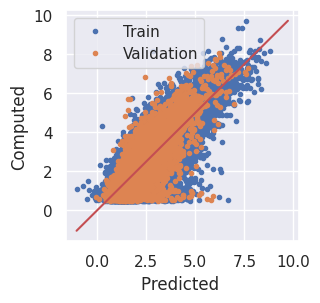

Epoch: 136, Train MAE: 0.8020, Val MAE: 0.8750
Epoch: 137, Train MAE: 0.8042, Val MAE: 0.9002
Epoch: 138, Train MAE: 0.8068, Val MAE: 0.8915
Epoch: 139, Train MAE: 0.7978, Val MAE: 0.8926
Epoch: 140, Train MAE: 0.7988, Val MAE: 0.8809


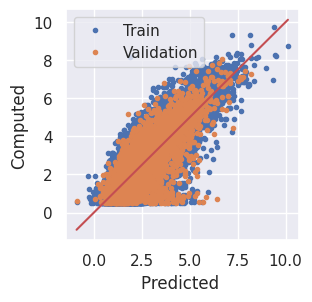

Epoch: 141, Train MAE: 0.7991, Val MAE: 0.8730
Epoch: 142, Train MAE: 0.8010, Val MAE: 0.8798
Epoch: 143, Train MAE: 0.7971, Val MAE: 0.8797
Epoch: 144, Train MAE: 0.7968, Val MAE: 0.8856
Epoch: 145, Train MAE: 0.7933, Val MAE: 0.8810


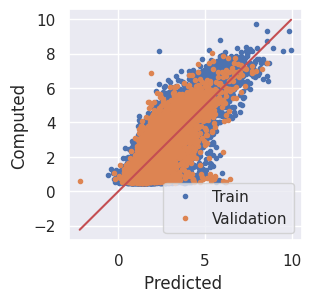

Epoch: 146, Train MAE: 0.7954, Val MAE: 0.9155
Epoch: 147, Train MAE: 0.7987, Val MAE: 0.8748
Epoch: 148, Train MAE: 0.7927, Val MAE: 0.8826
Epoch: 149, Train MAE: 0.7888, Val MAE: 0.8835
Epoch: 150, Train MAE: 0.7873, Val MAE: 0.8652


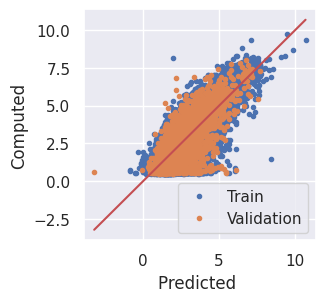

Epoch: 151, Train MAE: 0.7887, Val MAE: 0.8741
Epoch: 152, Train MAE: 0.7920, Val MAE: 0.8845
Epoch: 153, Train MAE: 0.7822, Val MAE: 0.8674
Epoch: 154, Train MAE: 0.7865, Val MAE: 0.9111
Epoch: 155, Train MAE: 0.7841, Val MAE: 0.8707


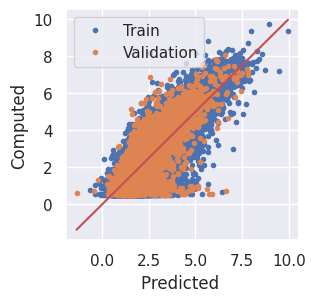

Epoch: 156, Train MAE: 0.7840, Val MAE: 0.8763
Epoch: 157, Train MAE: 0.7776, Val MAE: 0.8801
Epoch: 158, Train MAE: 0.7812, Val MAE: 0.8712
Epoch: 159, Train MAE: 0.7804, Val MAE: 0.9120
Epoch: 160, Train MAE: 0.7844, Val MAE: 0.8643


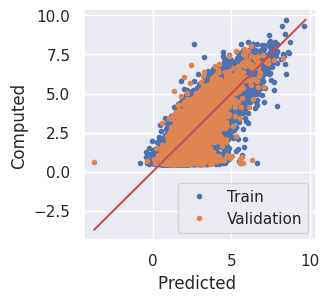

Epoch: 161, Train MAE: 0.7841, Val MAE: 0.8722
Epoch: 162, Train MAE: 0.7782, Val MAE: 0.8744
Epoch: 163, Train MAE: 0.7755, Val MAE: 0.8786
Epoch: 164, Train MAE: 0.7759, Val MAE: 0.8764
Epoch: 165, Train MAE: 0.7758, Val MAE: 0.8813


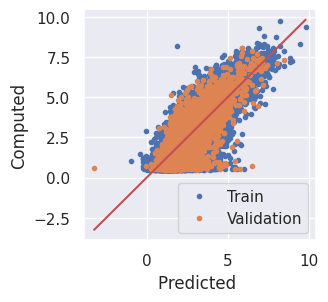

Epoch: 166, Train MAE: 0.7790, Val MAE: 0.8662
Epoch: 167, Train MAE: 0.7719, Val MAE: 0.8773
Epoch: 168, Train MAE: 0.7722, Val MAE: 0.8673
Epoch: 169, Train MAE: 0.7716, Val MAE: 0.8642
Epoch: 170, Train MAE: 0.7714, Val MAE: 0.8730


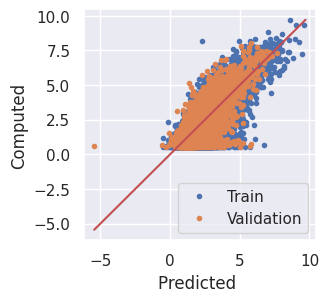

Epoch: 171, Train MAE: 0.7702, Val MAE: 0.8801
Epoch: 172, Train MAE: 0.7711, Val MAE: 0.8729
Epoch: 173, Train MAE: 0.7722, Val MAE: 0.8735
Epoch: 174, Train MAE: 0.7681, Val MAE: 0.8734
Epoch: 175, Train MAE: 0.7705, Val MAE: 0.8616


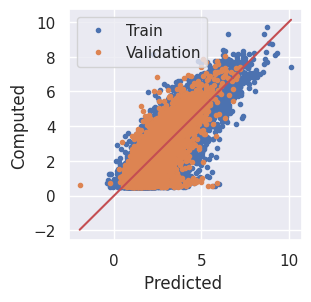

Epoch: 176, Train MAE: 0.7691, Val MAE: 0.8675
Epoch: 177, Train MAE: 0.7698, Val MAE: 0.8602
Epoch: 178, Train MAE: 0.7626, Val MAE: 0.8733
Epoch: 179, Train MAE: 0.7661, Val MAE: 0.8701
Epoch: 180, Train MAE: 0.7645, Val MAE: 0.8807


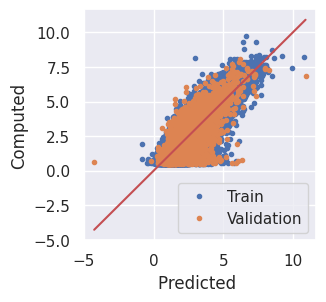

Epoch: 181, Train MAE: 0.7661, Val MAE: 0.8627
Epoch: 182, Train MAE: 0.7604, Val MAE: 0.8803
Epoch: 183, Train MAE: 0.7608, Val MAE: 0.8557
Epoch: 184, Train MAE: 0.7628, Val MAE: 0.8724
Epoch: 185, Train MAE: 0.7623, Val MAE: 0.8730


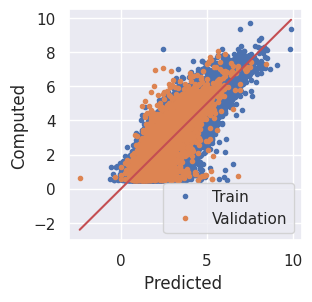

Epoch: 186, Train MAE: 0.7593, Val MAE: 0.8951
Epoch: 187, Train MAE: 0.7570, Val MAE: 0.8680
Epoch: 188, Train MAE: 0.7613, Val MAE: 0.8669
Epoch: 189, Train MAE: 0.7563, Val MAE: 0.8704
Epoch: 190, Train MAE: 0.7602, Val MAE: 0.8709


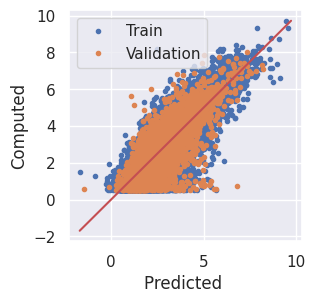

Epoch: 191, Train MAE: 0.7538, Val MAE: 0.8554
Epoch: 192, Train MAE: 0.7585, Val MAE: 0.8742
Epoch: 193, Train MAE: 0.7534, Val MAE: 0.8726
Epoch: 194, Train MAE: 0.7520, Val MAE: 0.8720
Epoch: 195, Train MAE: 0.7538, Val MAE: 0.8740


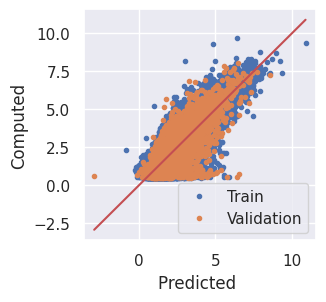

Epoch: 196, Train MAE: 0.7503, Val MAE: 0.8595
Epoch: 197, Train MAE: 0.7531, Val MAE: 0.8513
Epoch: 198, Train MAE: 0.7493, Val MAE: 0.8637
Epoch: 199, Train MAE: 0.7483, Val MAE: 0.8758
Epoch: 200, Train MAE: 0.7486, Val MAE: 0.8625


In [8]:
# Train the model
train_losses = []
val_losses   = []
for epoch in np.arange(0, n_epochs):
    train_loss, train_predictions, train_ground_truths = train(model, criterion, train_loader,
                                                               target_factor.to(device),
                                                               standardized_parameters['target_mean'].to(device),
                                                               optimizer)
    val_loss,   val_predictions,   val_ground_truths   =  test(model, criterion, val_loader,
                                                               target_factor.to(device),
                                                               standardized_parameters['target_mean'].to(device))

    # Pass to energy units (same as initial Fv)
    train_loss = np.sqrt(train_loss) * target_factor.item()
    val_loss   = np.sqrt(val_loss)   * target_factor.item()

    if epoch%5 == 0:
        stack = np.concatenate([train_predictions, train_ground_truths,
                                val_predictions,   val_ground_truths])
    
        _min_ = np.min(stack)
        _max_ = np.max(stack)
    
        plt.figure(figsize=(3, 3))
        plt.plot(train_predictions, train_ground_truths, '.', label='Train')
        plt.plot(val_predictions,   val_ground_truths,   '.', label='Validation')
        plt.xlabel(r'Predicted ')
        plt.ylabel(r'Computed')
        plt.plot([_min_, _max_], [_min_, _max_], '-r')
        plt.legend(loc='best')
        plt.show()
    
    # Append losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Check early stopping criteria
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print('Early stopping')
        break

    print(f'Epoch: {epoch+1}, Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}')

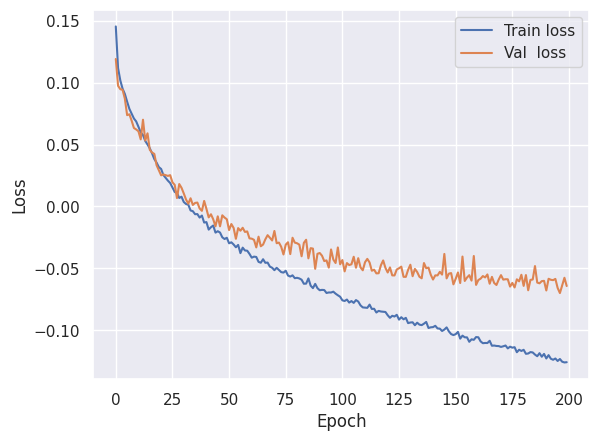

In [9]:
plt.plot(np.log10(train_losses), label='Train loss')
plt.plot(np.log10(val_losses) , label='Val  loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

# Check test data

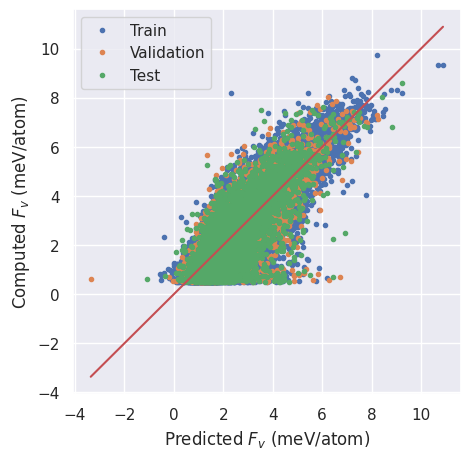

Train MAE: 0.7492, Val MAE: 0.8634, Test MAE: 0.8925


In [10]:
train_loss, train_predictions, train_ground_truths = train(model, criterion, train_loader,
                                                           target_factor.to(device),
                                                           standardized_parameters['target_mean'].to(device),
                                                           optimizer)
val_loss,   val_predictions,   val_ground_truths   =  test(model, criterion, val_loader,
                                                           target_factor.to(device),
                                                           standardized_parameters['target_mean'].to(device))
test_loss,  test_predictions,  test_ground_truths  =  test(model, criterion, test_loader,
                                                           target_factor.to(device),
                                                           standardized_parameters['target_mean'].to(device))

# Pass to energy units (same as initial Fv)
train_loss = np.sqrt(train_loss) * target_factor.item()
val_loss   = np.sqrt(val_loss)   * target_factor.item()
test_loss  = np.sqrt(test_loss)  * target_factor.item()

stack = np.concatenate([train_predictions, train_ground_truths,
                        val_predictions,   val_ground_truths,
                        test_predictions,  test_ground_truths])

_min_ = np.min(stack)
_max_ = np.max(stack)

plt.figure(figsize=(5, 5))
plt.plot(train_predictions, train_ground_truths, '.', label='Train')
plt.plot(val_predictions,   val_ground_truths,   '.', label='Validation')
plt.plot(test_predictions,  test_ground_truths,  '.', label='Test')
plt.xlabel(r'Predicted $F_v$ (meV/atom)')
plt.ylabel(r'Computed $F_v$ (meV/atom)')
plt.plot([_min_, _max_], [_min_, _max_], '-r')
plt.legend(loc='best')
plt.savefig(f'{target_folder}/{target}-GCNN-training.pdf', dpi=dpi, bbox_inches='tight')
plt.show()

print(f'Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}, Test MAE: {test_loss:.4f}')